In [1]:
# customary imports:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import glob
import os
import tqdm
from sklearn.model_selection import StratifiedKFold

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


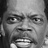

In [3]:
# loading a sample image
sample_image = Image.open("/content/gdrive/My Drive/Train/01_Angry/10.jpg")
sample_image

In [4]:
np.array(sample_image).shape


(48, 48)

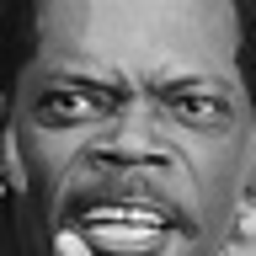

In [5]:
sample_image = sample_image.resize([256,256])
sample_image

In [6]:
np.array(sample_image).shape


(256, 256)

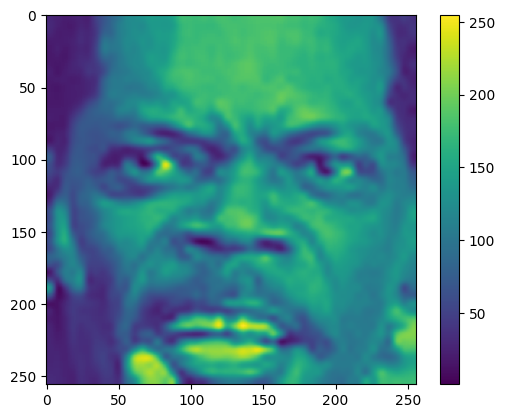

In [7]:
plt.imshow(np.array(sample_image))
plt.colorbar()

# Extract only face from images


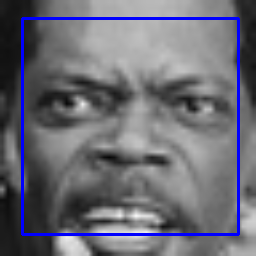

In [8]:
from google.colab.patches import cv2_imshow
import cv2

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# Read the input image
img = cv2.imread('/content/gdrive/My Drive/Train/01_Angry/10.jpg')
img = cv2.resize(img, dsize=(256,256))
# Convert into grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Detect faces
faces = face_cascade.detectMultiScale(gray, 1.1, 4)
# Draw rectangle around the faces
for (x, y, w, h) in faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)
    cropped_img= img[x:x+w, y:y+h]
    cropped_img=cv2.resize(cropped_img, (256,256), interpolation = cv2.INTER_AREA)
    # Display the output
cv2_imshow(img)


In [9]:
cropped_img.shape

(256, 256, 3)

In [10]:
cropped_img = cropped_img.sum(axis=2)

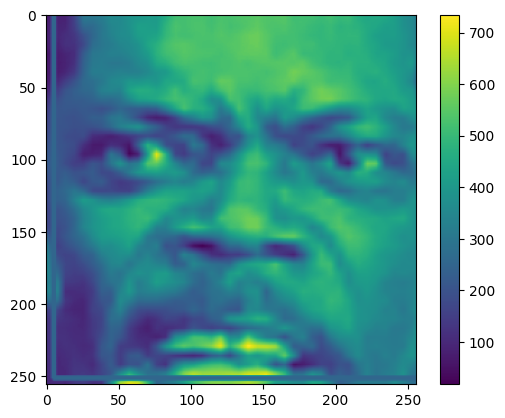

In [11]:
plt.imshow(cropped_img)
plt.colorbar()

# Load Data and Extract only Face


In [12]:
import cv2

In [13]:
def load_extract_normalize(image_path, normalized=True):
    # Read the input image and resize
    img = cv2.imread(image_path)
    img = cv2.resize(img, dsize=(256,256))
    # Convert into grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Detect faces
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    # crop faces
    for (x, y, w, h) in faces:
        cropped_img= img[x:x+w, y:y+h].astype('float32')
        cropped_img=cv2.resize(cropped_img, (256,256), interpolation = cv2.INTER_AREA)
        cropped_img = cropped_img.sum(axis=2)

    if normalized:
        if len(faces)!=0:
          return np.array(cropped_img).astype(np.float32) / 255.0
        else:
          return np.array(img).astype(np.float32) / 255.0
    else:
        if len(faces)!=0:
          return np.array(cropped_img).astype(np.float32)
        else:
          return np.array(img).astype(np.float32)

In [14]:
def load_normalize(image_path, normalized=True):
    image = Image.open(image_path).resize([200,200])
    # if len(np.array(image).shape) == 3:
    #     image = image.sum(axis=2)
    if normalized:
        return np.array(image).astype(np.float32) / 255.0
    else:
        return np.array(image).astype(np.float32)

In [15]:
# code to load all the data, assuming dataset is at /workspaces/awesome-ml-group/00_source_data/images/train
emo_types = ['01_Angry', '02_Disgust', '03_Fear', '04_Happy', '05_Neutral', '06_Bad', '07_Surprise']
emo_inds = np.arange(0, len(emo_types))
x_data = []
y_data = []

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/content/gdrive/My Drive/Train', emo_types[emo_ind],'*.jpg'))
    # x_data += [load_extract_normalize(image_path) for image_path in all_images]
    x_data += [load_normalize(image_path) for image_path in all_images]
    y_data += [emo_ind]*len(all_images)

In [16]:
x_data

[array([[0.11372549, 0.12156863, 0.14509805, ..., 0.04705882, 0.04705882,
         0.04705882],
        [0.11764706, 0.1254902 , 0.14901961, ..., 0.04705882, 0.04705882,
         0.04705882],
        [0.1254902 , 0.13333334, 0.15686275, ..., 0.04705882, 0.04705882,
         0.04705882],
        ...,
        [0.18039216, 0.18431373, 0.18431373, ..., 0.19607843, 0.19607843,
         0.19215687],
        [0.1882353 , 0.18431373, 0.18431373, ..., 0.20392157, 0.20392157,
         0.2       ],
        [0.1882353 , 0.1882353 , 0.1882353 , ..., 0.20392157, 0.20392157,
         0.2       ]], dtype=float32),
 array([[0.31764707, 0.31764707, 0.31764707, ..., 0.41568628, 0.41568628,
         0.41568628],
        [0.31764707, 0.31764707, 0.31764707, ..., 0.41568628, 0.41568628,
         0.41568628],
        [0.31764707, 0.31764707, 0.31764707, ..., 0.41568628, 0.41568628,
         0.41568628],
        ...,
        [0.70980394, 0.70980394, 0.70980394, ..., 0.8509804 , 0.8509804 ,
         0.8509804 

In [17]:
for i,img in enumerate(x_data):
  if len(img.shape) == 3:
    x_data[i] = img.sum(axis=2)

(18980, 200, 200, 1) (18980, 7)
(4745, 200, 200, 1) (4745, 7)


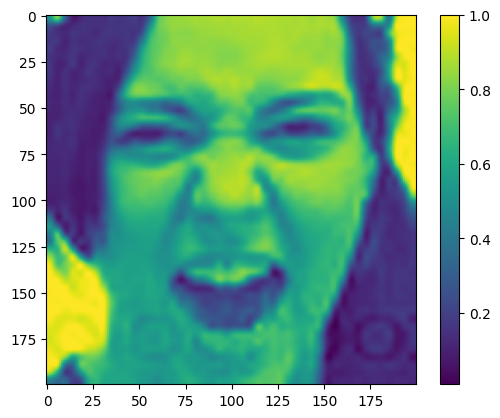

In [18]:
# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 200, 200, 1)
y_data = np.array(y_data)

folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()
# shuffling
np.random.shuffle(train_indices)

x_train = x_data[train_indices]
y_train = np.eye(len(emo_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(emo_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:,0])
plt.colorbar()

In [19]:
# train and fit a resnet50 model
resnet50_model = tf.keras.applications.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=x_train[0].shape, pooling=None, classes=7)
# model summary
resnet50_model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 1)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [20]:
# callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [21]:
# compile the model
resnet50_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # pick an optimizer and learning rate
                        loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss
                        metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor

In [22]:
n_epoch = 30
# train the model
resnet50_model.fit(x_train, y_train,
                epochs=n_epoch,
                batch_size=32,
                validation_data=(x_val, y_val),
                callbacks=[callback])

Epoch 1/30
594/594 [==============================] - 107s 104ms/step - loss: 1.6508 - categorical_accuracy: 0.3164 - val_loss: 1.8235 - val_categorical_accuracy: 0.3488
Epoch 2/30
594/594 [==============================] - 59s 99ms/step - loss: 1.4339 - categorical_accuracy: 0.4305 - val_loss: 1.6022 - val_categorical_accuracy: 0.4095
Epoch 3/30
594/594 [==============================] - 59s 100ms/step - loss: 1.2487 - categorical_accuracy: 0.5201 - val_loss: 1.5035 - val_categorical_accuracy: 0.4468
Epoch 4/30
594/594 [==============================] - 59s 99ms/step - loss: 1.1147 - categorical_accuracy: 0.5718 - val_loss: 1.7210 - val_categorical_accuracy: 0.4681
Epoch 5/30
594/594 [==============================] - 59s 100ms/step - loss: 0.9740 - categorical_accuracy: 0.6279 - val_loss: 1.4896 - val_categorical_accuracy: 0.4386
Epoch 6/30
594/594 [==============================] - 59s 99ms/step - loss: 0.8532 - categorical_accuracy: 0.6793 - val_loss: 2.3052 - val_categorical_accur

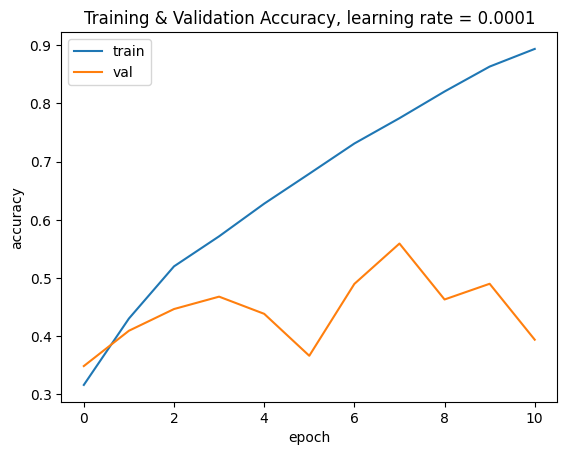

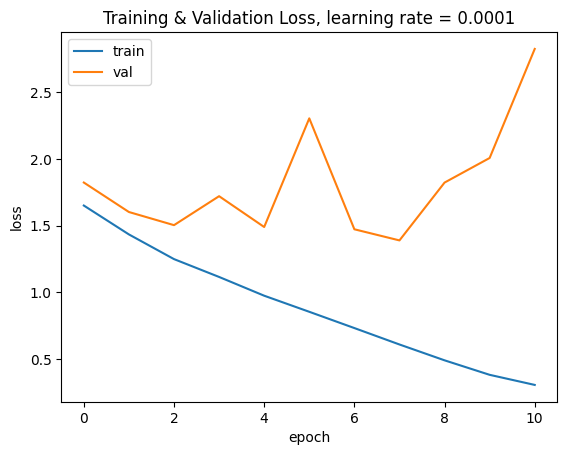

In [23]:
# save the model
resnet50_model.save('resnet50_model.h5')

# plot the accuracy and loss
plt.plot(resnet50_model.history.history['categorical_accuracy'])
plt.plot(resnet50_model.history.history['val_categorical_accuracy'])
plt.title('Training & Validation Accuracy, learning rate = 0.0001')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(resnet50_model.history.history['loss'])
plt.plot(resnet50_model.history.history['val_loss'])
plt.title('Training & Validation Loss, learning rate = 0.0001')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [24]:
resnet50_model.save('/content/gdrive/My Drive/IDS705/resnet50_model')


Seems overfitted. Next step is try to reduce overfitting.

## Batch Normalisation and Drop Out

In [25]:
# batch normalization and dropout
# train and fit a resnet50 model
resnet50_model_bn = tf.keras.applications.ResNet50(include_top=True, weights=None, input_tensor=None, input_shape=x_train[0].shape, pooling=None, classes=7)
# model summary
resnet50_model_bn.summary()

# add batch normalization and dropout
for layer in resnet50_model_bn.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    if isinstance(layer, tf.keras.layers.Dropout):
        layer.trainable = True



Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 1)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  3200        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [26]:
# callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# compile the model
resnet50_model_bn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),  # pick an optimizer and learning rate
                        loss=tf.keras.losses.CategoricalCrossentropy(),  # pick a loss  
                        metrics=tf.keras.metrics.CategoricalAccuracy())  # pick a metric to monitor



In [27]:
n_epoch = 30
# train the model
resnet50_model_bn.fit(x_train, y_train,
                epochs=n_epoch,
                batch_size=32,
                validation_data=(x_val, y_val),
                callbacks=[callback])



Epoch 1/30
594/594 [==============================] - 96s 103ms/step - loss: 1.6437 - categorical_accuracy: 0.3219 - val_loss: 1.8125 - val_categorical_accuracy: 0.2417
Epoch 2/30
594/594 [==============================] - 59s 100ms/step - loss: 1.4219 - categorical_accuracy: 0.4370 - val_loss: 2.3937 - val_categorical_accuracy: 0.2295
Epoch 3/30
594/594 [==============================] - 59s 100ms/step - loss: 1.2187 - categorical_accuracy: 0.5260 - val_loss: 2.3004 - val_categorical_accuracy: 0.2847
Epoch 4/30
594/594 [==============================] - 59s 100ms/step - loss: 1.0701 - categorical_accuracy: 0.5899 - val_loss: 1.6937 - val_categorical_accuracy: 0.4449
Epoch 5/30
594/594 [==============================] - 60s 102ms/step - loss: 0.9426 - categorical_accuracy: 0.6419 - val_loss: 1.4012 - val_categorical_accuracy: 0.5452
Epoch 6/30
594/594 [==============================] - 59s 100ms/step - loss: 0.8253 - categorical_accuracy: 0.6890 - val_loss: 1.4575 - val_categorical_acc

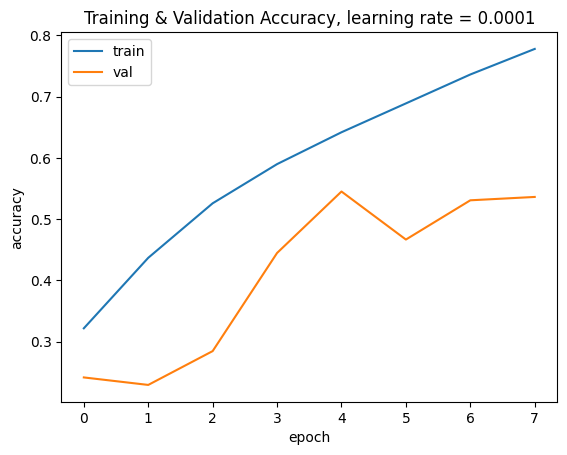

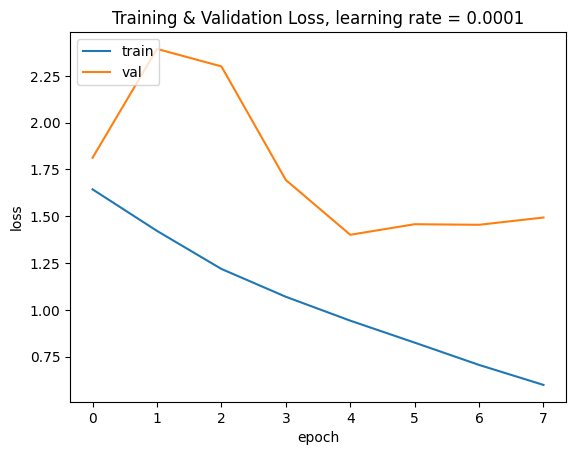

In [28]:
# plot the accuracy and loss
plt.plot(resnet50_model_bn.history.history['categorical_accuracy'])
plt.plot(resnet50_model_bn.history.history['val_categorical_accuracy'])
plt.title('Training & Validation Accuracy, learning rate = 0.0001')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(resnet50_model_bn.history.history['loss'])
plt.plot(resnet50_model_bn.history.history['val_loss'])
plt.title('Training & Validation Loss, learning rate = 0.0001')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [29]:
# save the model
resnet50_model_bn.save('/content/gdrive/My Drive/IDS705/resnet50_model_bn')